# Tarea Almacenamiento y captura de datos

> Integrantes: Thamara López, Fabián Ortega

Realice un proceso de web scraping para el sitio https://jetsmart.com/cl/es/. Para ello realice las siguientes tareas:  

1) Utilizar Selenium para emular un navegador y cargar la página requerida (1 punto).  
2) Buscar vuelos desde Santiago a Arica del 1 de febrero al 28 de febrero utilizando los campos de inputs del buscador de la página (1 punto).
3) Una vez en la página de resultados, extraiga la información de precios y fechas de vuelos de ida y de vuelta para todos los días de febrero y genere un dataframe con la información de precios y fechas (2 puntos).  
4) Crear una base de datos sqlite con la información del dataframe (1 punto).  
5) Realizar una consulta SQL para seleccionar los vuelos de ida y vuelta con el precio total mínimo (1 punto).  

Utilizando la API de Twitter, realice las siguientes tareas:

1) Extraer los últimos 1.000 tweets de tu usuario preferido que escriba en español (1 punto).  
2) Hacer un análisis de frecuencia de palabras (100 palabras más frecuentes), habiendo removido primero stopwords y usando tokenización en español (2 puntos).  
3) Extraer 100 usuarios con perfil público que son seguidos por su usuario de preferencia y extraer los últimos 10 tweets de cada uno de esos usuarios (1 punto).  
4) Hacer un análisis de frecuencia de palabras igual al de la parte b) (100 palabras más frecuentes), de los tweets extraídos en la parte c) (2 puntos).   




Cada pregunta tiene una escala de 1 a 7. El promedio de ambas preguntas resulta en la nota final de la tarea. 

In [104]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import pandas as pd
import re
import sqlite3 as sql

## Scraping con Selenium

Funciones auxiliares para simplificar el scraping

In [105]:
def ClickOn(xpath, error=True, time_sleep=2):
    '''Función para hacer click según xpath'''
    try: 
        WebDriverWait(driver, 5)\
            .until(EC.element_to_be_clickable((By.XPATH,
                                            xpath)))\
            .click()
        time.sleep(time_sleep)
    except:
        if error == True:
            raise('Error')
        else:
            pass

def SendKey(xpath, key,error=True, time_sleep=2):
    '''Función para enviar keys a input  según xpath'''
    try: 
        WebDriverWait(driver, 5)\
            .until(EC.element_to_be_clickable((By.XPATH,
                                            xpath)))\
            .send_keys(key)
        time.sleep(time_sleep)
    except:
        if error == True:
            raise('Error')
        else:
            pass

def Find(xpath):
    txt = driver.find_element_by_xpath(xpath)

    return txt.text
    

Creamos driver

In [106]:
options =  webdriver.ChromeOptions()
options.add_argument('--start-maximized')
options.add_argument('--disable-extensions')
driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
driver.implicitly_wait(3)



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/97.0.4692.71/chromedriver_mac64.zip
Driver has been saved in cache [/Users/fabianalexis/.wdm/drivers/chromedriver/mac64/97.0.4692.71]
/var/folders/l4/br6xdwsn3wj7ntybwy6zwmvh0000gn/T/ipykernel_34728/2803746617.py:4: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)


In [107]:
# Xpath del botón de cierre del modal que aparece al entrar en la página
btn_close = '/html/body/div[1]/main/div[7]/div/div[6]/div/div/div[1]/button'
modal = '/html/body/div[5]/div/div/div[2]/button[2]'
# Página jetsmart
driver.get('https://jetsmart.com/cl/es/')
time.sleep(5)
ClickOn(btn_close, error=False, time_sleep=3) # función para hacer click por xpath
ClickOn(modal, error=False)

In [109]:
# Xpaths
origen = '/html/body/div[1]/main/div[2]/searchbox/div/div/div[1]/div/form/route-selector/div[1]/input[1]'
scl = '/html/body/div[1]/main/div[2]/searchbox/div/div/div[1]/div/form/route-selector/div[2]/div[3]/ul/li[1]'
destino = '/html/body/div[1]/main/div[2]/searchbox/div/div/div[1]/div/form/route-selector/div[1]/input[2]'
ar = '/html/body/div[1]/main/div[2]/searchbox/div/div/div[1]/div/form/route-selector/div[2]/div[3]/ul/li[2]'
next_month = '/html/body/div[1]/main/div[2]/searchbox/div/div/div[1]/div/form/date-selector/div[3]/div[2]/div/div[1]/span[2]'
fecha_inicio = '/html/body/div[1]/main/div[2]/searchbox/div/div/div[1]/div/form/date-selector/div[3]/div[2]/div/div[2]/div/div[2]/div[2]/span[2]'
search = '/html/body/div[1]/main/div[2]/searchbox/div/div/div[1]/div/form/div[2]/button'

# Funciones para indicar destinto y fecha de vuelos.

ClickOn(origen)
ClickOn(scl)
ClickOn(destino)
ClickOn(ar)
#ClickOn(next_month)
ClickOn(fecha_inicio)
ClickOn(fecha_inicio, error=False)
ClickOn(search)

Generamos código que scrapea en página de vuelos obteniendo el precio de ida y vuelta hasta el 28 de febrero

In [54]:
fecha = '/html/body/app/div/div/div[2]/div/section/div/dummy-flight/ac-flight-page/div/form[1]/div[1]/section/div[1]/ac-flight-fee-option-list/div[2]/header/div/div[1]/label/span'
precio_ida = '/html/body/app/div/div/div[2]/div/section/div/dummy-flight/ac-flight-page/div/form[1]/div[1]/section/div[1]/ac-flight-fee-option-list/div[2]/ul/ac-flight-fee-option[1]/li/div/div/div/div/div[2]/div[2]/ac-flight-fare/div/div[1]/div'
next_btn = '/html/body/app/div/div/div[2]/div/section/div/dummy-flight/ac-flight-page/div/form[1]/div[1]/section/div[1]/ac-flight-fee-option-list/div[1]/div[2]/i'
precio_vuelta = '/html/body/app/div/div/div[2]/div/section/div/dummy-flight/ac-flight-page/div/form[1]/div[1]/section/div[2]/ac-flight-fee-option-list/div[2]/ul/ac-flight-fee-option/li/div/div/div/div/div[2]/div[2]/ac-flight-fare/div/div[1]'
p_ida = []
d_ida = []
p_vuelta = []

i = 0
while i < 28:
    # Precios de ida
    price_ida = Find(precio_ida).replace('$ ','').replace('.', '')
    date_ida = re.sub(".* ", "",Find(fecha))
    print(date_ida)
    print(price_ida)
    p_ida.append(price_ida)
    d_ida.append(date_ida)

    # Precios de vuelta
    price_vuelta = Find(precio_vuelta).replace('$ ','').replace('.', '')
    print(price_vuelta)
    p_vuelta.append(price_vuelta)

    ClickOn(next_btn, time_sleep=4)
    i = int(date_ida.replace('-02',""))

01-02
99000
25000
02-02
52000
25000
03-02
52000
46000
04-02
46000
34000
05-02
34000
34000
06-02
39000
39000
07-02
39000
34000
08-02
34000
25000
09-02
34000
29000
10-02
52000
46000
11-02
39000
29000
12-02
34000
34000
13-02
25000
46000
14-02
29000
46000
15-02
34000
52000
16-02
25000
39000
17-02
46000
39000
18-02
25000
29000
19-02
29000
39000
20-02
25000
46000
21-02
25000
39000
22-02
25000
34000
23-02
25000
29000
24-02
39000
39000
25-02
25000
29000
26-02
29000
29000
27-02
25000
29000
28-02
25000
29000


Generamos dataframe con los datos scrapeados

In [157]:
viaje = pd.DataFrame({'fecha_ida':d_ida, 'precio_ida':p_ida,
'fecha_vuelta':d_ida, 'precio_vuelta':p_vuelta})
# Separo fecha en día y mes
viaje['dia'] = viaje.fecha_ida.str.split("-", expand=True)[0]
viaje['mes'] = viaje.fecha_ida.str.split("-", expand=True)[1]
viaje.head()

,fecha_ida,precio_ida,fecha_vuelta,precio_vuelta,dia,mes
0,01-02,99000,01-02,25000,01,02
1,02-02,52000,02-02,25000,02,02
2,03-02,52000,03-02,46000,03,02
3,04-02,46000,04-02,34000,04,02
4,05-02,34000,05-02,34000,05,02


In [158]:
viaje = viaje.drop(['fecha_ida', 'fecha_vuelta'], axis=1)

In [160]:
viaje.dia = viaje.dia.map(int)
viaje.mes = viaje.mes.map(int)
viaje.head()

,precio_ida,precio_vuelta,dia,mes
0,99000,25000,1,2
1,52000,25000,2,2
2,52000,46000,3,2
3,46000,34000,4,2
4,34000,34000,5,2


### Creamos base de datos sqlite

In [161]:
conn = sql.connect('data/viajes.db')
viaje.to_sql('viajes', conn)

In [162]:
cur = conn.cursor()
cur.execute("SELECT dia, mes, precio_ida, precio_vuelta FROM  viajes")

In [163]:
rows = cur.fetchall()
rows[0:10]

[(1, 2, '99000', '25000'),
 (2, 2, '52000', '25000'),
 (3, 2, '52000', '46000'),
 (4, 2, '46000', '34000'),
 (5, 2, '34000', '34000'),
 (6, 2, '39000', '39000'),
 (7, 2, '39000', '34000'),
 (8, 2, '34000', '25000'),
 (9, 2, '34000', '29000'),
 (10, 2, '52000', '46000')]

Obtengo precio de ida más bajo

In [164]:
pd.read_sql('''SELECT  dia, MIN(precio_ida) as precio_ida_minimo
FROM    viajes''', conn)
## La fecha de ida con el precio minimo es el 13-02, el cual es de 25.000 clp

,dia,precio_ida_minimo
0,13,25000


Obtengo precio de vuelta más bajo según fecha de viaje de ida (viaje de vuelta no puede ser antes del día 13)

In [167]:
pd.read_sql('''SELECT  dia, MIN(precio_vuelta) as precio_ida_minimo
FROM    viajes
WHERE dia >= 13''', conn)

,dia,precio_ida_minimo
0,18,29000


R: El precio de ida y vuelta más barato es de 54.000 clp

## Api de Twitter

In [85]:
import tweepy
import nltk
import matplotlib.pyplot as plt
import numpy as np

#nltk.download('stopwords')
"""
APIKEY: Kc9E3xJmZUITHEhii1i3S85iE
APISECRET: sUVaD0VjOR5apQFWxeVjiPH0r6iZahEr622Bbq0na9ActasiuT
BEARERTOKEN: AAAAAAAAAAAAAAAAAAAAAFQ%2BXgEAAAAA%2Bn%2BXUX4uJYuiroHFVGmsO1KU9GE%3DSK6mzHKNUOMEvYn1eXeeNN9EjdX3LXd3LdsReMJsVTyqMT9vZv
ACCESTOKEN: 1474440209123233794-QiBVSHyk2PaWVFtzZ5pslmE0WMcZ19
SECRETTOKEN: 21XIOqWl3dnSPue2TJoeMwf0zsRHkVZkErLKr99TAsYvv
"""

bearerToken = 'AAAAAAAAAAAAAAAAAAAAAFQ%2BXgEAAAAA%2Bn%2BXUX4uJYuiroHFVGmsO1KU9GE%3DSK6mzHKNUOMEvYn1eXeeNN9EjdX3LXd3LdsReMJsVTyqMT9vZv'


In [66]:
client = tweepy.Client(bearer_token=bearerToken)

In [67]:
cnnUser = client.get_user(username="Bototos")
usrId, name, usrName = cnnUser.data.values()

In [69]:
cnnTweets = tweepy.Paginator(client.get_users_tweets, usrId, max_results=100).flatten(limit=1000)

In [70]:
listTweets = [tweet for tweet in cnnTweets]  

In [71]:
listTweets = [tweet.text for tweet in listTweets]

In [73]:
stopwords = []

# Cambiar pathFile que tengas disponible de stopwords por ruta de archivo
pathFile = "data/spanish"
with open(pathFile, "r", encoding="utf-8") as stopwordsFile:
    
    for word in stopwordsFile:
        word = word.rstrip()
        stopwords.append(word)

symbols = "!¡?¿#@$%&/\\=|_°,.;:[]()^*+-\"“”1234567890' \\n"

In [74]:
def get_dict_freq_words(listTweets):
    dict_words = {}
    listOfWords = []
    for msg in listTweets:
        # Se separan palabras por espacios
        wordsOfMsg = msg.split(" ")
        # Se eliminan simbolos y palabras de parada

        if wordsOfMsg:
            for word in wordsOfMsg:
                
                word = word.rstrip()
                word = word.lower()
                word.strip(symbols)

                if word != "" and word not in stopwords and not "http://" in word and not "https://" in word:
                    listOfWords.append(word)
            
        # Se arma diccionario de frecuencia de palabras con las palabras limpias
        for word in listOfWords:

            if dict_words.get(word) is None:
                dict_words[word] = 1
            
            else:
                dict_words[word] += 1

    if(dict_words.get("") is not None):     # Asegurar que no queden palabras vacias
        del dict_words[""]
    
    return(dict_words)

In [75]:
dict_freq_word = get_dict_freq_words(listTweets=listTweets)

In [76]:
def sort_words_by_freq(dict_freq_word):
    freqWordsList = dict_freq_word.items()
    freqWordsList = list(freqWordsList)

    for i in range(len(freqWordsList)):
        for j in range(0, len(freqWordsList) - 1 - i):
            if(freqWordsList[j][1] < freqWordsList[j + 1][1]):
                freqWordsList[j], freqWordsList[j + 1] = freqWordsList[j + 1], freqWordsList[j]
    
    return freqWordsList

In [77]:
freqWordsList = sort_words_by_freq(dict_freq_word)

In [78]:
# 100 primeras palabras mas frecuentes en los 1000 ultimos tweets
freqWordsList[:100]

[('rt', 115490),
 ('¿quién', 34918),
 ('@bototos', 33680),
 ('ministra', 32713),
 ('si', 28731),
 ('ministro', 21471),
 ('ruido', 19585),
 ('@sototov:', 18701),
 ('1.', 17959),
 ('gustaría', 17699),
 ('enojaría', 17699),
 ('𝗱𝗲', 17032),
 ('😍\n\n2.', 16248),
 ('barrio', 15834),
 ('menos', 13547),
 ('barrios', 13180),
 ('fuentes', 11270),
 ('igual', 10287),
 ('@enzillo3', 10104),
 ('gente', 10015),
 ('clase', 8923),
 ('solo', 8748),
 ('así', 8635),
 ('@paulie_alvarez', 8594),
 ('ser', 8403),
 ('pues', 8091),
 ('hacer', 8075),
 ('no.', 8060),
 ('ver', 7861),
 ('¿y', 7427),
 ('puede', 7059),
 ('mayor', 6443),
 ('densidad', 6341),
 ('ustedes', 6256),
 ('@falsochante', 6222),
 ('creo', 6134),
 ('mismo', 6054),
 ('después', 5882),
 ('mejor', 5826),
 ('ministro…', 5813),
 ('pobres', 5736),
 ('@redkiun', 5646),
 ('alguien', 5593),
 ('nadie', 5374),
 ('externas', 5153),
 ('no,', 5053),
 ('vivir', 5035),
 ('casa', 5013),
 ('@sototov', 4977),
 ('exposición', 4967),
 ('nunca', 4962),
 ('@gondan06',

In [79]:
df = pd.DataFrame.from_records(freqWordsList[:100], columns =['Word', 'n'])
df = df.head()
df

,Word,n
0,rt,115490
1,¿quién,34918
2,@bototos,33680
3,ministra,32713
4,si,28731


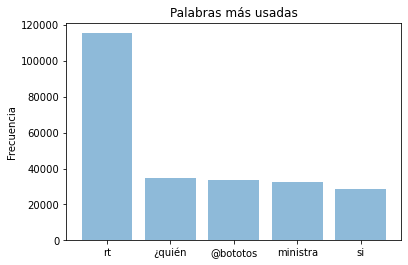

In [101]:
words = tuple(df.Word)
y_pos = np.arange(len(words))
n = np.array(df.n)


plt.bar(y_pos, n, align='center', alpha=0.5)
plt.xticks(y_pos, words)
plt.ylabel('Frecuencia')
plt.title('Palabras más usadas')

plt.show()


In [99]:
"""
followingUsrs: Usuarios al que sigue el usuario(usrId)
followerUsrs: Usuarios que siguen al usuario(usrId)
"""

followingUsrs = client.get_users_following(id=usrId)
followingUsrs = followingUsrs.data

usersId = [user.id for user in followingUsrs]

In [100]:
tweetsPerUsers = []

for id in usersId:
    tweets = client.get_users_tweets(id=id, max_results=10)
    tweets = tweets.data
    
    if tweets:
        tweetsPerUsers.append(tweets)

In [102]:
listTweets = []

for tweets in tweetsPerUsers:
    if tweets:
        for tweet in tweets:
            listTweets.append(tweet.text)

In [103]:
# Se arma diccionario de palabras y frecuencias
dict_freq_word = get_dict_freq_words(listTweets=listTweets)

# Se arma lista de palabras y frecuencias ordenadas de mayor a menor por frecuencia de palabra
freqWordsList = sort_words_by_freq(dict_freq_word)

In [30]:
freqWordsList[:100]

[('rt', 138838),
 ('the', 104815),
 ('to', 78540),
 ('and', 59366),
 ('of', 46454),
 ('in', 41479),
 ('for', 33855),
 ('|', 33251),
 ('is', 26676),
 ('our', 23742),
 ('on', 22111),
 ('hoy', 20185),
 ('we', 20089),
 ('with', 19139),
 ('do', 18690),
 ('junto', 16458),
 ('chile', 15591),
 ('si', 14367),
 ('&amp;', 14266),
 ('are', 13416),
 ('em', 13382),
 ('casos', 13198),
 ('rights', 13129),
 ('año', 12931),
 ('dos', 12759),
 ('at', 12135),
 ('from', 11874),
 ('ministro', 11683),
 ('it', 11300),
 ('have', 11151),
 ('comuna', 10551),
 ('van', 10516),
 ('presidente', 10345),
 ('da', 10328),
 ('by', 10310),
 ('be', 10142),
 ('this', 10000),
 ('ser', 9842),
 ('👉', 9819),
 ('nueva', 9671),
 ('i', 9626),
 ('san', 9609),
 ('parte', 9524),
 ('trabajo', 9369),
 ('will', 9367),
 ('domicilio', 9171),
 ('2', 9060),
 ('proyecto', 8852),
 ('2021', 8641),
 ('años', 8609),
 ('was', 8440),
 ('conocer', 8412),
 ('invitamos', 8352),
 ('as', 8257),
 ('bomberos', 8011),
 ('that', 7998),
 ('gobierno', 7905),
